In [1]:
import os

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torchvision import transforms, io
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
manualSeed = 42
torch.manual_seed(manualSeed)

In [3]:
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda'

In [4]:
# Number of channels in the training images. For color images this is 3
nc = 512

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

lr = 0.0001
num_epochs = 100
batch_size = 128 

Define model architecture

In [5]:
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=512):
        super(Generator, self).__init__()
        self.nz = nz
        self.ngf = ngf
        self.nc = nc
        
        self.main = nn.Sequential(
            nn.Conv2d( self.nz, self.ngf * 8, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(inplace = True),

            nn.Conv2d(self.ngf * 8, self.ngf * 4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace = True),

            nn.Conv2d( self.ngf * 4, self.ngf * 2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace = True),

            nn.Conv2d( self.ngf * 2, self.ngf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf*4),
            nn.ReLU(inplace = True),

            nn.Conv2d( self.ngf*4, self.nc, 1, 1, 0, bias=True),
        )

    def forward(self, input):
        return self.main(input)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, nc=512, ndf=64):
        super(Discriminator, self).__init__()
        self.nc = nc
        self.ndf = ndf
        self.main = nn.Sequential(
            nn.Conv2d(self.nc, self.ndf*8, 1, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(self.ndf*8, self.ndf*4, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(self.ndf*4, self.ndf*2, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(self.ndf*2, self.ndf, 1, 1, 0, bias=False),
            nn.BatchNorm2d(self.ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(self.ndf, 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

initialize the networks

In [7]:
netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
netD = Discriminator(nc=nc, ndf=ndf).to(device)

In [8]:
imagenet_name = 'tiny_imagenet'
cifar10_name = 'cifar10'
fmnist_name = 'fmnist'
emnist_name = 'emnist'

imagenet_input_folder_name = '/kaggle/input/'+ imagenet_name +'_features_in_resnet18/'
cifar10_input_folder_name = '/kaggle/input/'+cifar10_name+'_features_in_resnet18/'
fmnist_input_folder_name = '/kaggle/input/'+fmnist_name+'_features_in_resnet18/'
emnist_input_folder_name = '/kaggle/input/'+emnist_name+'_features_in_resnet18/'

imagenet_model_name = '_model_' + imagenet_name + '_'
cifar10_model_name = '_model_' + cifar10_name + '_'
fmnist_model_name = '_model_' + fmnist_name + '_'
emnist_model_name = '_model_' + emnist_name + '_'

In [9]:
input_folder_name = imagenet_input_folder_name
model_name = imagenet_model_name

loading models

In [11]:
# netD.load_state_dict(torch.load('./netD'+ model_name + 'v1.0.pt'))
# netG.load_state_dict(torch.load('./netG' + model_name + 'v1.0.pt'))

training

data setup for training

In [12]:
WholeFeatVec = torch.load(input_folder_name + 'train.pt')

WholeFeatVec.unsqueeze_(-1).unsqueeze_(-1)
print(WholeFeatVec.shape)

torch.Size([100000, 512, 1, 1])


In [13]:
class FeatDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.current_set_len = data.shape[0]        
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        curdata = self.data[idx]        
        return curdata

In [14]:
trainset_closeset = FeatDataset(data=WholeFeatVec)
dataloader = DataLoader(trainset_closeset, batch_size=batch_size, shuffle=True)

setup training

In [15]:
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr/1.5, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [16]:
img_list = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    epoch_G_losses = []
    epoch_D_losses = []
    for data in dataloader:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype = torch.float32)
        
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()
        

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()
        
        epoch_G_losses.append(errG.item())
        epoch_D_losses.append(errD.item())

    mean_G_loss = np.mean(epoch_G_losses)
    mean_D_loss = np.mean(epoch_D_losses)
        
    print(f"EPOCH#{epoch:3d},\t Loss_D: {mean_D_loss:8.6f} \t Loss_G: {mean_G_loss:8.6f}")

    G_losses.append(mean_G_loss)
    D_losses.append(mean_D_loss)

EPOCH#  0,	 Loss_D: 1.299272 	 Loss_G: 0.757739
EPOCH#  1,	 Loss_D: 1.160435 	 Loss_G: 0.875866
EPOCH#  2,	 Loss_D: 0.951308 	 Loss_G: 1.093214
EPOCH#  3,	 Loss_D: 0.773195 	 Loss_G: 1.289885
EPOCH#  4,	 Loss_D: 0.453949 	 Loss_G: 1.734828
EPOCH#  5,	 Loss_D: 0.530091 	 Loss_G: 1.885865
EPOCH#  6,	 Loss_D: 0.286178 	 Loss_G: 2.128190
EPOCH#  7,	 Loss_D: 0.207780 	 Loss_G: 2.567952
EPOCH#  8,	 Loss_D: 0.233548 	 Loss_G: 2.824186
EPOCH#  9,	 Loss_D: 0.297020 	 Loss_G: 2.785454
EPOCH# 10,	 Loss_D: 0.236779 	 Loss_G: 2.860162
EPOCH# 11,	 Loss_D: 0.119750 	 Loss_G: 3.063947
EPOCH# 12,	 Loss_D: 0.090107 	 Loss_G: 3.454210
EPOCH# 13,	 Loss_D: 0.081549 	 Loss_G: 3.648794
EPOCH# 14,	 Loss_D: 0.065674 	 Loss_G: 3.908354
EPOCH# 15,	 Loss_D: 0.058090 	 Loss_G: 4.157943
EPOCH# 16,	 Loss_D: 0.040567 	 Loss_G: 4.395303
EPOCH# 17,	 Loss_D: 0.034085 	 Loss_G: 4.526316
EPOCH# 18,	 Loss_D: 0.032978 	 Loss_G: 4.578278
EPOCH# 19,	 Loss_D: 0.029267 	 Loss_G: 4.647519
EPOCH# 20,	 Loss_D: 0.023785 	 Loss_G: 4

In [17]:
torch.save(netD.state_dict(), './netD' + model_name + 'v1.0.pt')
torch.save(netG.state_dict(), './netG' + model_name + 'v1.0.pt')

drawing the error curves

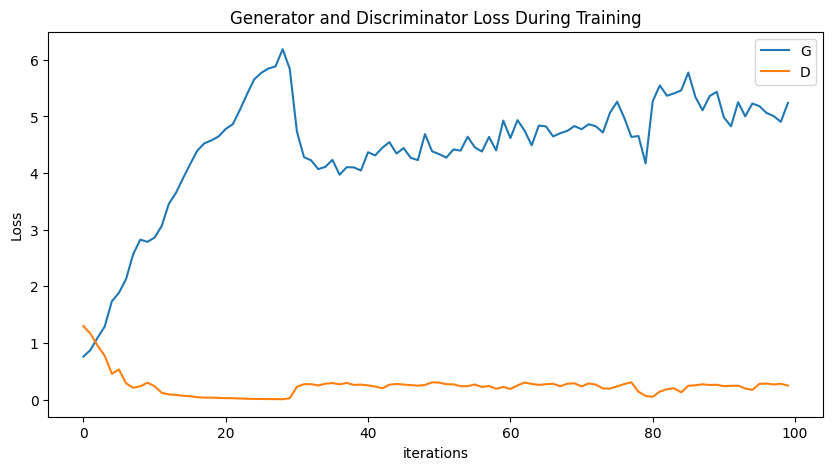

In [18]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

test

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, f1_score

def evaluate_openset(scores_closeset, scores_openset):    
    y_true = np.array([0] * len(scores_closeset) + [1] * len(scores_openset))
    y_discriminator = np.concatenate([scores_closeset, scores_openset])
    auc_d, roc_to_plot = plot_roc(y_true, y_discriminator, 'Discriminator ROC')
    return auc_d, roc_to_plot


def plot_roc(y_true, y_score, title="Receiver Operating Characteristic", **options):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    roc_to_plot = {'tp':tpr, 'fp':fpr, 'thresh':thresholds, 'auc_score':auc_score}

    return auc_score, roc_to_plot

running discriminator on closed test-set

In [20]:
testset_closeset = torch.load(input_folder_name + 'test.pt')
testset_closeset = testset_closeset.unsqueeze_(-1).unsqueeze_(-1).cuda()
dataloader_test_closeset = DataLoader(testset_closeset, batch_size=batch_size, shuffle=True)

conf_close_set = torch.tensor([]).type(torch.float)

for feats in dataloader_test_closeset:    
    predConf = netD(feats)    
    predConf = predConf.view(-1,1)
    conf_close_set = torch.cat((conf_close_set, predConf.reshape(-1).detach().cpu()), 0)
        
conf_close_set = conf_close_set.detach().cpu().numpy()
print(conf_close_set.shape)

(10000,)


running discriminator on tiny_imagenet test-set (open test-set)

In [21]:
testset_openset = torch.load(imagenet_input_folder_name + 'test.pt')
testset_openset = testset_openset.unsqueeze_(-1).unsqueeze_(-1).cuda()
dataloader_test_openset = DataLoader(testset_openset, batch_size=batch_size, shuffle=True)

conf_open_imagenet = torch.tensor([]).type(torch.float)

for feats in dataloader_test_openset:
    predConf = netD(feats)
    predConf = predConf.view(-1,1).detach()
    conf_open_imagenet = torch.cat((conf_open_imagenet, predConf.reshape(-1).detach().cpu()), 0)

conf_open_imagenet = conf_open_imagenet.detach().cpu().numpy()        
print(conf_close_set.shape, conf_open_imagenet.shape)

(10000,) (10000,)


0.5050212249999999


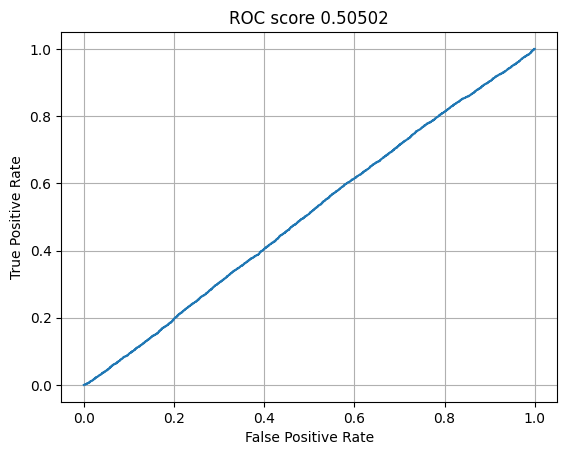

In [22]:
roc_score, roc_to_plot = evaluate_openset(-conf_close_set, -conf_open_imagenet)

plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))
print(roc_score)

running discriminator on CIFAR10 test-set (open test-set)

In [23]:
testset_openset = torch.load(cifar10_input_folder_name + 'test.pt')
testset_openset = testset_openset.unsqueeze_(-1).unsqueeze_(-1).cuda()
dataloader_test_openset = DataLoader(testset_openset, batch_size=batch_size, shuffle=True)

conf_open_cifar10 = torch.tensor([]).type(torch.float)

for feats in dataloader_test_openset:
    predConf = netD(feats)
    predConf = predConf.view(-1,1).detach()
    conf_open_cifar10 = torch.cat((conf_open_cifar10, predConf.reshape(-1).detach().cpu()), 0)

conf_open_cifar10 = conf_open_cifar10.detach().cpu().numpy()        
print(conf_close_set.shape, conf_open_cifar10.shape)

(10000,) (10000,)


0.9980350700000001


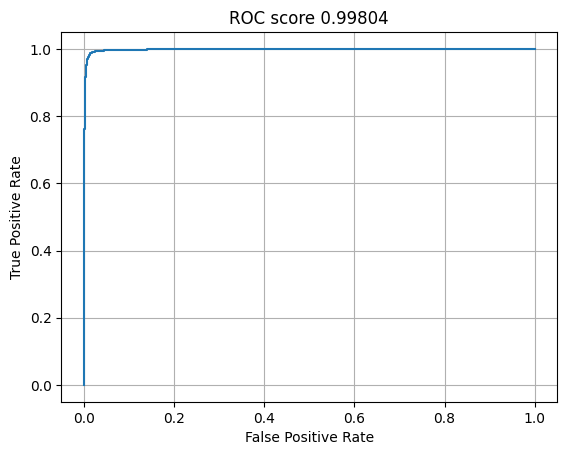

In [24]:
roc_score, roc_to_plot = evaluate_openset(-conf_close_set, -conf_open_cifar10)

plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))
print(roc_score)

running discriminator on fmnist test-set (open test-set)

In [25]:
testset_openset = torch.load(fmnist_input_folder_name + 'test.pt')
testset_openset = testset_openset.unsqueeze_(-1).unsqueeze_(-1).cuda()
dataloader_test_openset = DataLoader(testset_openset, batch_size=batch_size, shuffle=True)

conf_open_fmnist = torch.tensor([]).type(torch.float)

for feats in dataloader_test_openset:
    predConf = netD(feats)
    predConf = predConf.view(-1,1).detach()
    conf_open_fmnist = torch.cat((conf_open_fmnist, predConf.reshape(-1).detach().cpu()), 0)

conf_open_fmnist = conf_open_fmnist.detach().cpu().numpy()        
print(conf_close_set.shape, conf_open_fmnist.shape)

(10000,) (10000,)


0.9918172049999999


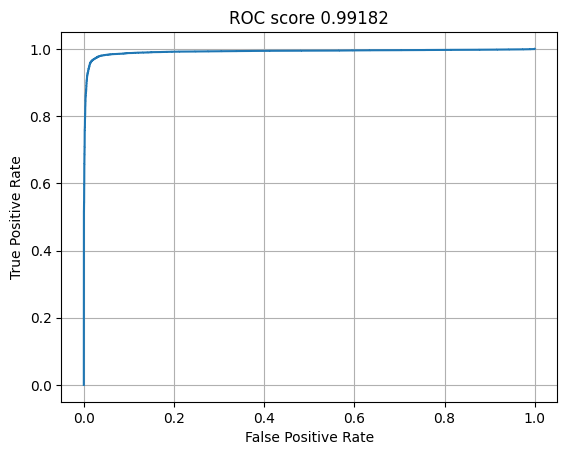

In [26]:
roc_score, roc_to_plot = evaluate_openset(-conf_close_set, -conf_open_fmnist)

plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))
print(roc_score)

running discriminator on emnist test-set (open test-set)

In [27]:
testset_openset = torch.load(emnist_input_folder_name + 'test.pt')
testset_openset = testset_openset.unsqueeze_(-1).unsqueeze_(-1).cuda()
dataloader_test_openset = DataLoader(testset_openset, batch_size=batch_size, shuffle=True)

conf_open_emnist = torch.tensor([]).type(torch.float)

for feats in dataloader_test_openset:
    predConf = netD(feats)
    predConf = predConf.view(-1,1).detach()
    conf_open_emnist = torch.cat((conf_open_emnist, predConf.reshape(-1).detach().cpu()), 0)

conf_open_emnist = conf_open_emnist.detach().cpu().numpy()        
print(conf_close_set.shape, conf_open_emnist.shape)

(10000,) (18799,)


0.9950414702909729


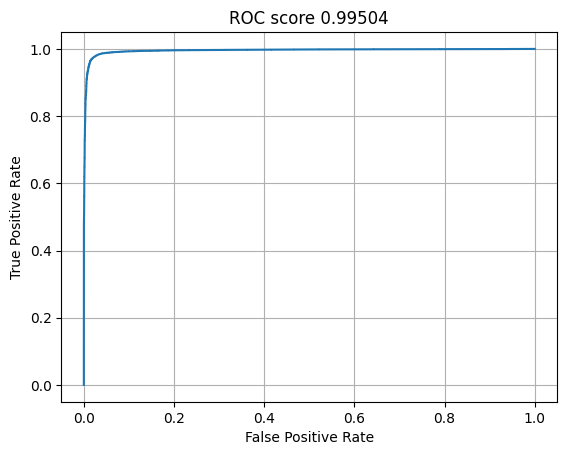

In [28]:
roc_score, roc_to_plot = evaluate_openset(-conf_close_set, -conf_open_emnist)

plt.plot(roc_to_plot['fp'], roc_to_plot['tp'])
plt.grid('on')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC score {:.5f}'.format(roc_score))
print(roc_score)